In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving SMILES_Big_Data_Set.csv to SMILES_Big_Data_Set.csv


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch [1/10], Loss: 0.7076
Epoch [2/10], Loss: 0.6757
Epoch [3/10], Loss: 0.6684
Epoch [4/10], Loss: 0.6552
Epoch [5/10], Loss: 0.6414
Epoch [6/10], Loss: 0.6304
Epoch [7/10], Loss: 0.6173
Epoch [8/10], Loss: 0.6061
Epoch [9/10], Loss: 0.5961
Epoch [10/10], Loss: 0.5855


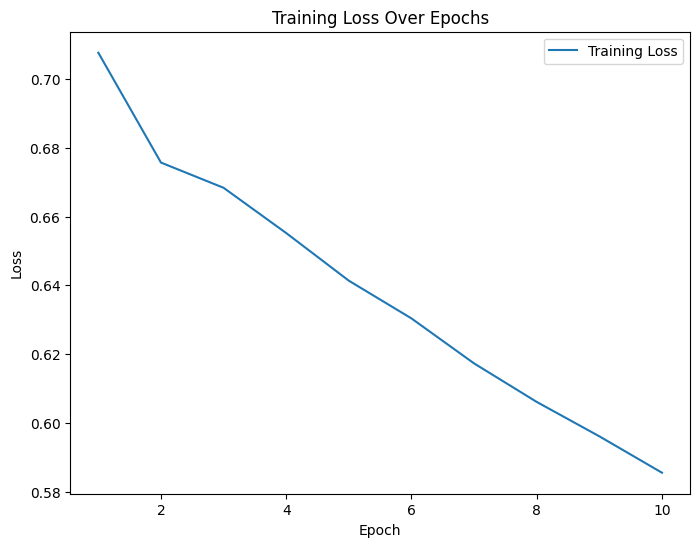

Accuracy: 0.7045, Precision: 0.7182, F1-score: 0.7518


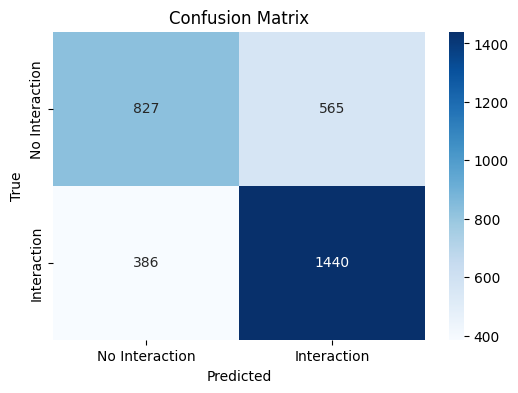

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('SMILES_Big_Data_Set.csv')

threshold = df['pIC50'].median()
df['interaction'] = (df['pIC50'] >= threshold).astype(int)

tokenizer = RobertaTokenizer.from_pretrained('seyonec/ChemBERTa-zinc-base-v1')
model = RobertaModel.from_pretrained('seyonec/ChemBERTa-zinc-base-v1')

def get_embeddings_batch(smiles_list):
    inputs = tokenizer(smiles_list, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

batch_size = 32
embeddings = []
for i in range(0, len(df), batch_size):
    batch_smiles = df['SMILES'][i:i + batch_size].tolist()
    batch_embeddings = get_embeddings_batch(batch_smiles)
    embeddings.extend(batch_embeddings)

df_embeddings = pd.DataFrame(embeddings)
df = pd.concat([df.reset_index(drop=True), df_embeddings], axis=1)

X = torch.tensor(list(df_embeddings.values))
y = torch.tensor(df['interaction'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class DTIClassifier(nn.Module):
    def __init__(self, input_size):
        super(DTIClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DTIClassifier(input_size=X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.to(device).float())
    loss = criterion(outputs, y_train.to(device).long())
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    outputs = model(X_test.to(device).float())
    _, predicted = torch.max(outputs, 1)
    acc = accuracy_score(y_test.cpu(), predicted.cpu())
    precision = precision_score(y_test.cpu(), predicted.cpu())
    f1 = f1_score(y_test.cpu(), predicted.cpu())
    print(f'Accuracy: {acc:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}')

cm = confusion_matrix(y_test.cpu(), predicted.cpu())
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Interaction', 'Interaction'], yticklabels=['No Interaction', 'Interaction'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
